In [1]:
import os
import gc
import parse
import logging
import numpy as np
import pandas as pd
from typing import List

from utils import get_N_tokens, read_and_split_file, raw_dir, interim_dir, final_dir, load_SET_dataset

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

# Generating train dataset and splitting it in train and test

In [2]:
texts, labels = list(), list()

files = ["bswac_tail_pp", "cnrwac_tail_pp", "hrwac_tail_pp", "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})


from sklearn.model_selection import train_test_split

train, eval_df = train_test_split(train, test_size=0.1, stratify=train.labels)


In [3]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()


def get_stats(N: int, train=train, eval_df=eval_df, clf=clf):
    import gc
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics import (
        f1_score,
        ConfusionMatrixDisplay,
        confusion_matrix,
        accuracy_score,
    )

    gc.collect()
    vocabulary = get_N_tokens(N)

    def get_coverage(s:str) -> int:
        """Calculates how many vocabulary tokens are in the string.

        Args:
            s (str): input string

        Returns:
            int: number of DISTINCT vocabulary tokens in input string.
        """        
        word_set = set(s.split(" "))
        return len(word_set.intersection(vocabulary))
    vectorizer = CountVectorizer(vocabulary=vocabulary, lowercase=True, binary=True)
    
    eval_df["coverage"] = eval_df.text.apply(get_coverage)
    average_coverage = eval_df.coverage.mean()


    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels
    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels


    clf.fit(train_vectors.toarray(), train_labels)
    y_pred = clf.predict(test_vectors.toarray())

    LABELS = ["hr", "bs", "sr", "me"]

    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS, average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    return {"N": N, "microF1": micro, "macroF1": macro, "accuracy": acc, "cm": cm,
    "coverage": average_coverage, "clf": clf.__str__()}


In [19]:
Ns = np.logspace(1, 4, 30, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf)
        rezdict["eval_df"] = "web crawl 10%"
        results.append(rezdict)
    except MemoryError:
        break


2022-01-07 12:35:53,250 - N=10
2022-01-07 12:36:40,842 - N=12
2022-01-07 12:37:28,457 - N=16
2022-01-07 12:38:16,192 - N=20
2022-01-07 12:39:03,849 - N=25
2022-01-07 12:39:51,963 - N=32
2022-01-07 12:40:40,896 - N=41
2022-01-07 12:41:30,293 - N=52
2022-01-07 12:42:20,436 - N=67
2022-01-07 12:43:11,997 - N=85
2022-01-07 12:44:03,919 - N=108
2022-01-07 12:44:56,110 - N=137
2022-01-07 12:45:50,652 - N=174
2022-01-07 12:46:47,238 - N=221
2022-01-07 12:47:45,354 - N=280
2022-01-07 12:48:46,289 - N=356
2022-01-07 12:49:50,573 - N=452
2022-01-07 12:50:58,804 - N=573
2022-01-07 12:52:12,370 - N=727
2022-01-07 12:53:30,910 - N=923
2022-01-07 12:54:56,160 - N=1172
2022-01-07 12:56:30,037 - N=1487
2022-01-07 12:58:13,983 - N=1887
2022-01-07 13:00:09,429 - N=2395
2022-01-07 13:02:17,655 - N=3039
2022-01-07 13:04:44,601 - N=3856
2022-01-07 13:07:31,998 - N=4893
2022-01-07 13:10:47,409 - N=6210


In [20]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("17_results_NB_on_10_percent_of_web_data_extended.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,eval_df
N,,,,,,,
10,0.387931,0.348746,0.387931,"[[6136, 21, 65, 21], [6278, 457, 624, 205], [2...",0.690446,GaussianNB(),web crawl 10%
12,0.403606,0.362078,0.403606,"[[6125, 28, 68, 22], [6000, 506, 839, 219], [2...",0.834899,GaussianNB(),web crawl 10%
16,0.437313,0.398791,0.437313,"[[6120, 30, 71, 22], [5755, 653, 925, 231], [2...",1.073957,GaussianNB(),web crawl 10%
20,0.468402,0.428018,0.468402,"[[6108, 35, 68, 32], [5457, 737, 1025, 345], [...",1.363647,GaussianNB(),web crawl 10%
25,0.497717,0.455735,0.497717,"[[6105, 34, 69, 35], [5227, 808, 1097, 432], [...",1.692337,GaussianNB(),web crawl 10%
32,0.514236,0.470399,0.514236,"[[6100, 31, 75, 37], [5017, 856, 1158, 533], [...",1.988163,GaussianNB(),web crawl 10%
41,0.535321,0.490184,0.535321,"[[6106, 30, 71, 36], [4894, 933, 1131, 606], [...",2.381504,GaussianNB(),web crawl 10%
52,0.550298,0.504707,0.550298,"[[6120, 31, 72, 20], [4799, 1009, 1120, 636], ...",2.869245,GaussianNB(),web crawl 10%
67,0.571208,0.525454,0.571208,"[[6104, 40, 78, 21], [4568, 1130, 1157, 709], ...",3.525258,GaussianNB(),web crawl 10%


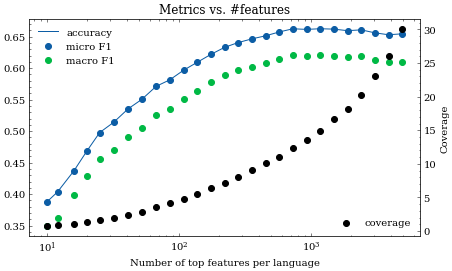

In [21]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.xlabel("Number of top features per language")

ax = plt.gca()
ax2 = plt.twinx()

ax2.scatter(rezdf.index, rezdf["coverage"], label="coverage", c="k")
ax2.set_ylabel("Coverage")
ax2.legend(loc="lower right")

plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/17_in_domain_coverage.png")
plt.show()

In [22]:
from sklearn.svm import LinearSVC
clf_lin_svc = LinearSVC(dual=False)
Ns = np.logspace(1, 4, 30, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf_lin_svc)
        rezdict["eval_df"] = "web crawl 10%"
        results.append(rezdict)
    except MemoryError:
        break


2022-01-07 13:18:55,652 - N=10
2022-01-07 13:19:45,352 - N=12
2022-01-07 13:20:35,144 - N=16
2022-01-07 13:21:26,188 - N=20
2022-01-07 13:22:17,124 - N=25
2022-01-07 13:23:10,601 - N=32
2022-01-07 13:24:04,408 - N=41
2022-01-07 13:25:00,313 - N=52
2022-01-07 13:25:56,505 - N=67
2022-01-07 13:26:55,486 - N=85
2022-01-07 13:27:58,584 - N=108
2022-01-07 13:29:01,551 - N=137
2022-01-07 13:30:08,731 - N=174
2022-01-07 13:31:17,859 - N=221
2022-01-07 13:32:27,717 - N=280
2022-01-07 13:33:45,523 - N=356
2022-01-07 13:35:05,961 - N=452
2022-01-07 13:36:29,095 - N=573
2022-01-07 13:37:57,151 - N=727
2022-01-07 13:39:29,420 - N=923
2022-01-07 13:41:06,913 - N=1172
2022-01-07 13:42:54,764 - N=1487
2022-01-07 13:44:48,185 - N=1887
2022-01-07 13:46:47,898 - N=2395
2022-01-07 13:49:03,187 - N=3039
2022-01-07 13:51:36,827 - N=3856
2022-01-07 13:54:38,002 - N=4893
2022-01-07 13:59:17,424 - N=6210


In [23]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("17_results_LinSVC_on_10_percent_of_web_data_extended.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,eval_df
N,,,,,,,
10,0.546227,0.413034,0.546227,"[[1327, 145, 63, 4708], [328, 658, 182, 6396],...",0.690446,LinearSVC(dual=False),web crawl 10%
12,0.555155,0.429995,0.555155,"[[1550, 136, 62, 4495], [414, 677, 188, 6285],...",0.834899,LinearSVC(dual=False),web crawl 10%
16,0.584964,0.483415,0.584964,"[[1836, 336, 67, 4004], [493, 1047, 217, 5807]...",1.073957,LinearSVC(dual=False),web crawl 10%
20,0.595870,0.501440,0.595870,"[[1961, 349, 66, 3867], [535, 1118, 223, 5688]...",1.363647,LinearSVC(dual=False),web crawl 10%
25,0.610790,0.526472,0.610790,"[[2197, 387, 61, 3598], [610, 1275, 236, 5443]...",1.692337,LinearSVC(dual=False),web crawl 10%
32,0.622219,0.544845,0.622219,"[[2381, 437, 59, 3366], [688, 1441, 241, 5194]...",1.988163,LinearSVC(dual=False),web crawl 10%
41,0.630478,0.558457,0.630478,"[[2479, 461, 60, 3243], [701, 1579, 240, 5044]...",2.381504,LinearSVC(dual=False),web crawl 10%
52,0.643624,0.578641,0.643624,"[[2620, 539, 59, 3025], [752, 1885, 233, 4694]...",2.869245,LinearSVC(dual=False),web crawl 10%
67,0.656071,0.595806,0.656071,"[[2790, 623, 57, 2773], [811, 2084, 238, 4431]...",3.525258,LinearSVC(dual=False),web crawl 10%


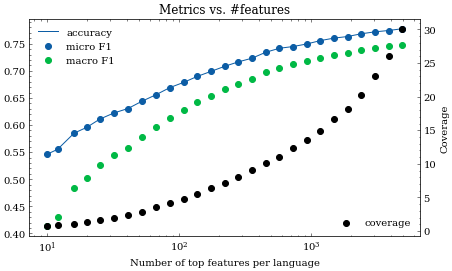

In [25]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.xlabel("Number of top features per language")

ax = plt.gca()
ax2 = plt.twinx()

ax2.scatter(rezdf.index, rezdf["coverage"], label="coverage", c="k")
ax2.set_ylabel("Coverage")
ax2.legend(loc="lower right")

plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/17_in_domain_coverage_LinSVC.png")
plt.show()

In [28]:
len(get_N_tokens(100))

781